In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20250310)

n = 10
w = 1024

int8_acts = np.zeros(n)

f32_acts = np.zeros(n)


sigma = 1/np.sqrt(w)
matrices = np.random.randn(n, w, w)*sigma

w_deltas =  (np.abs(matrices).max(axis=(1,2)))/ 127 # floats
quantized_matrices = np.round( matrices/ w_deltas[:,None,None] ).astype(np.int8) # in int8

matrices = (quantized_matrices.astype(np.int32) * w_deltas[:, None, None]) # in float

v_0 = np.round(np.random.randn(w)).astype(np.int8) # ATTENTION NUMPY HAS A DIFFERENT ROUNDING IMPLEMENTATION THAN TORCH

r_0 = np.round(np.random.randn(w)).astype(np.int8) # used for getting scaling parameters

v_delta = 1

## quantized matrix vector mul
v_int8 = v_0.copy()
for i,mat in enumerate(quantized_matrices):

    v_int32 = (mat.astype(np.int32) @ v_int8.astype(np.int32))
    v_f32 = v_int32 * w_deltas[i] * v_delta

    int8_acts[i] = (v_f32**2).mean()
    v_delta = np.abs(v_f32).max() / 127 
    v_int8 = (v_f32 / v_delta)
    v_int8 = np.round(v_int8).astype(np.int8)



# with np.printoptions(precision=3, suppress=True):
print(v_int8)


[ 35 -19 -21 ... -38 -12   6]


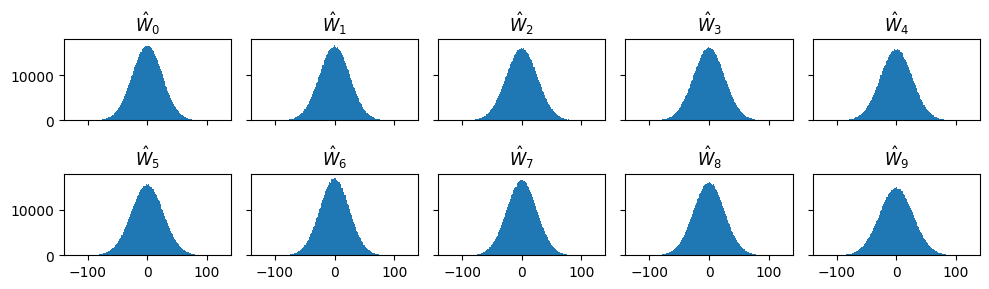

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)
bins = np.arange(-np.abs(quantized_matrices).max() - 0.5, np.abs(quantized_matrices).max() + 1.5)
for i, ax in enumerate(axs.flat):
    ax.hist(quantized_matrices[i ].ravel(), bins=bins)
    ax.set_title(r'$\hat{W}_{' + str(i) + r'}$')

[ 35. -17. -22. ... -38. -12.   7.]


Text(0.5, 1.0, 'Variance of activation in layer k as a function of k')

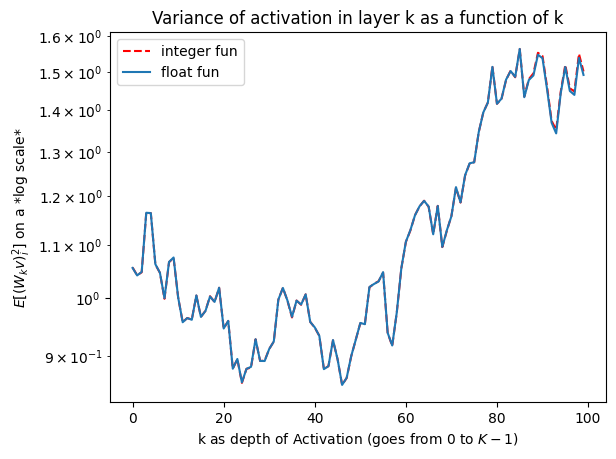

In [19]:
# checkup for the baseline
# using floating point W and v but quantising activations

v = v_0.copy().astype(np.int32)
for i,mat in enumerate(matrices):
    vector = mat @ v.astype(float)

    v_delta = np.abs(vector).max() / 127

    v_int = np.round(vector / v_delta) 
    vector = v_delta * v_int

    f32_acts[i] = (vector**2).mean()
    v = vector

print(v_int)

raw_var =  np.zeros((n))
v = v_0.copy().astype(np.float32)
# print(v)
for i,mat in enumerate(matrices):
    vector = mat @ v
    raw_var[i] = (vector **2).mean()

# with np.printoptions(precision=3, suppress=True):
#     print(f"MSE: {((vector -v_f32)**2).mean():.3f}")

plt.plot(int8_acts,"--r", label="integer fun")
plt.plot(f32_acts, label="float fun")
# plt.plot(raw_var, "-g", label="raw")
plt.legend()
plt.yscale("log")
plt.ylabel("$E[(W_kv)^2_i]$ on a *log scale*")
plt.xlabel("k as depth of Activation (goes from 0 to $K-1$)")
plt.title("Variance of activation in layer k as a function of k")

### Static quantization

Now let's try *static quantization* where the scaling factors for requantization are precomputed to save time during inference.
This is done in the first for-loop, scaling factors are stored in `v_deltas`.


[-0.06627248 -0.36053153 -1.22747307 ... -0.25198688  0.00750627
 -0.32342816]


Text(0.5, 1.0, 'Variance of activation in layer k as a function of k')

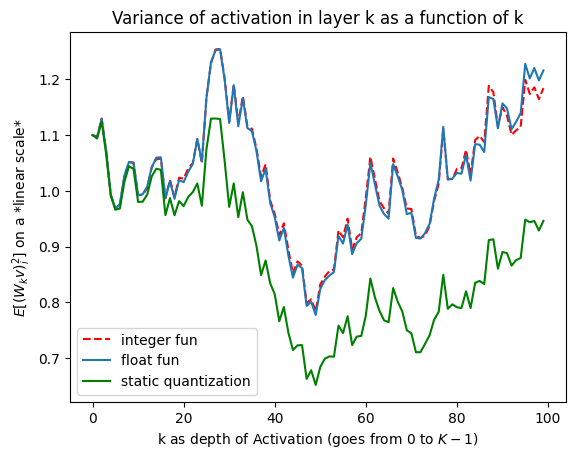

In [166]:

r_0 = np.round(np.random.randn(w)).astype(np.int8) # used for getting scaling parameters
v_int8 = r_0.copy().astype(np.int32)

v_deltas = np.ones(n)
int8_acts_static = np.zeros(n)

c = 0

for i,mat in enumerate(quantized_matrices):

    v_int32 = (mat.astype(np.int32) @ v_int8.astype(np.int32))

    if i == 0:
        v_f32 = v_int32 * w_deltas[i] 
    else:
        v_f32 = v_int32 * w_deltas[i] * v_deltas[i-1]

    v_deltas[i] = (np.abs(v_f32).max()) / 127 # this line saves scaling factors to the array for later use at inference
    v_int8 = (v_f32 / v_deltas[i])
    v_int8 = np.round(v_int8).astype(np.int8)
    

v_int8 = v_0.copy()
for i,mat in enumerate(quantized_matrices):

    v_int32 = (mat.astype(np.int32) @ v_int8.astype(np.int32))
    if i == 0:
        v_f32 = v_int32 * w_deltas[i] 
    else:
        v_f32 = v_int32 * w_deltas[i] * v_deltas[i-1]

    int8_acts_static[i] = (v_f32**2).mean()

    v_int8 = np.clip((v_f32 / v_deltas[i]), -127, 127)
    v_int8 = np.round(v_int8).astype(np.int8)

print(v_f32)

plt.plot(int8_acts,"--r", label="integer fun")
plt.plot(f32_acts, label="float fun")
plt.plot(int8_acts_static, "g", label="static quantization")
plt.legend()
# plt.yscale("log")
plt.ylabel("$E[(W_kv)^2_i]$ on a *linear scale*")
plt.xlabel("k as depth of Activation (goes from 0 to $K-1$)")
plt.title("Variance of activation in layer k as a function of k")

In [74]:
np.array([130]).astype(np.int8)

array([-126], dtype=int8)

In [73]:
np.abs(quantized_matrices).max(axis=(1,2))


array([127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127], dtype=int8)